In [1]:
# import libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob  # for sentiment analysis

import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from dateutil.parser import parse
import warnings
import seaborn as sns

# download nltk data
# nltk.download('stopwords')
# nltk.download('punkt_tab')

In [2]:
# load tesla data
tesla = pd.read_csv('data/tsla.csv')

# preprocess tesla data
tesla['Date'] = pd.to_datetime(tesla['Date'])
tesla.sort_values('Date', inplace=True)
tesla.reset_index(drop=True, inplace=True)


In [3]:
# load news data
reuters = pd.read_csv('data/reuters_headlines.csv')
guardian = pd.read_csv('data/guardian_headlines.csv')
cnbc = pd.read_csv('data/cnbc_headlines.csv')

# parse reuters dates
reuters['Date'] = pd.to_datetime(reuters['Time'], errors='coerce')

# parse guardian dates
guardian['Date'] = pd.to_datetime(guardian['Time'], format='%d-%b-%y', errors='coerce')

In [4]:
def parse_cnbc_time(time_str):
    try:
        time_str = time_str.strip().replace('ET', '').strip()
        dt = parse(time_str, fuzzy=True)
        return dt
    except:
        return pd.NaT

In [5]:
cnbc.dropna(subset=['Headlines', 'Time'], inplace=True)
cnbc['Date'] = cnbc['Time'].apply(parse_cnbc_time)

# rename headlines
reuters_news = reuters[['Date', 'Headlines']].rename(columns={'Headlines': 'Headline'})
guardian_news = guardian[['Date', 'Headlines']].rename(columns={'Headlines': 'Headline'})
cnbc_news = cnbc[['Date', 'Headlines']].rename(columns={'Headlines': 'Headline'})

# combine all news
news = pd.concat([reuters_news, guardian_news, cnbc_news], ignore_index=True)
news.dropna(subset=['Date'], inplace=True)

In [6]:
stop_words = set(stopwords.words('english'))

# clean headlines
def clean(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [7]:
news['Clean_Headline'] = news['Headline'].apply(clean)

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

news['Sentiment'] = news['Headline'].apply(get_sentiment)
daily_news = news.groupby('Date').agg({
    'Clean_Headline': ' '.join,
    'Sentiment': 'mean'
}).reset_index()

# merge with tesla data
merged = pd.merge(tesla, daily_news, on='Date', how='inner')

In [8]:
# create target: 1 if next day's close > today's close, else 0
merged['Target'] = (merged['Close'].shift(-1) > merged['Close']).astype(int)
merged.dropna(inplace=True)

# feature engineering: add lag features
for lag in [1, 2, 3]:
    merged[f'Close_Lag{lag}'] = merged['Close'].shift(lag)
    merged[f'Volume_Lag{lag}'] = merged['Volume'].shift(lag)
merged.dropna(inplace=True)

In [9]:
X_num = merged[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
               'Close_Lag1', 'Close_Lag2', 'Close_Lag3',
               'Volume_Lag1', 'Volume_Lag2', 'Volume_Lag3', 'Sentiment']]
X_text = merged['Clean_Headline']
y = merged['Target']

scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)
vectorizer = TfidfVectorizer(max_features=500)
X_text_vect = vectorizer.fit_transform(X_text).toarray()

# combine features
X = np.hstack((X_num.values, X_text_vect))

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [10]:
# tuning stage
xgb_params = {
    'tree_method': 'gpu_hist',
    'gpu_id': 0,   
    'n_estimators': 100,
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 158,
    'objective': 'binary:logistic',
    'use_label_encoder': False,
    'eval_metric': 'logloss'
}

model = xgb.XGBClassifier(**xgb_params)

# hyperparameter tuning
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 8],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

rand_search = RandomizedSearchCV(model, param_distributions=param_dist,
                                 n_iter=20, scoring='accuracy',
                                 cv=3, verbose=1, random_state=158, n_jobs=-1)
rand_search.fit(X_train, y_train)
best_model = rand_search.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\lxvel\Miniforge3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:58:36] WARNING: D:\bld\xgboost-split_1733179550881\work\src\common\error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)
c:\Users\lxvel\Miniforge3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:58:36] WARNING: D:\bld\xgboost-split_1733179550881\work\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\lxvel\Miniforge3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:58:36] WARNING: D:\bld\xgboost-split_1733179550881\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [11]:
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'accuracy: {accuracy:.2f}')
print('classification report:')
print(classification_report(y_test, y_pred))
print('confusion matrix:')
print(confusion_matrix(y_test, y_pred))

accuracy: 0.54
classification report:
              precision    recall  f1-score   support

           0       0.49      0.43      0.46        58
           1       0.58      0.63      0.60        71

    accuracy                           0.54       129
   macro avg       0.53      0.53      0.53       129
weighted avg       0.54      0.54      0.54       129

confusion matrix:
[[25 33]
 [26 45]]


c:\Users\lxvel\Miniforge3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:58:38] WARNING: D:\bld\xgboost-split_1733179550881\work\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\lxvel\Miniforge3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:58:38] WARNING: D:\bld\xgboost-split_1733179550881\work\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


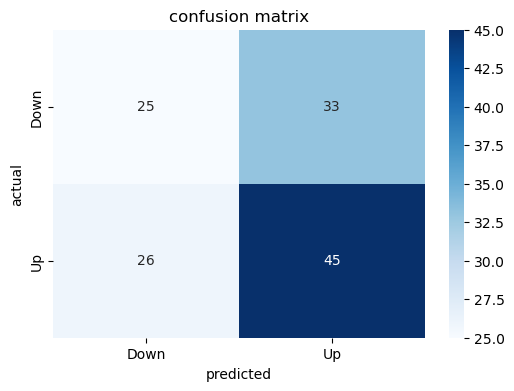

In [13]:
# plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('confusion matrix')
plt.show()